In [1]:
import zfit
import matplotlib.pyplot as plt
import numpy as np
from hepstats.hypotests.parameters import POI
from hepstats.hypotests.calculators import AsymptoticCalculator, FrequentistCalculator
from hepstats.hypotests import Discovery

/home/massimiliano/python-devel/anaconda3/envs/stats-studies/lib/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/home/massimiliano/python-devel/anaconda3/envs/stats-studies/lib/python3.9/site-packages/uproot/reading.py:186: FutureWarning: XRootD 5.1.1 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)


In [2]:
limits = (0, 300)

mu_true = 125
sigma_true = 0.6
tau_true = 0.01
frac_true = 0.0005

n_bkg = 1000000
n_sig = frac_true * n_bkg

data_sig = np.random.normal(loc=mu_true, scale=sigma_true, size=int(n_sig))
data_bkg = np.random.exponential(scale=1/tau_true, size=n_bkg)
data_n = np.concatenate([data_sig, data_bkg], axis=0)

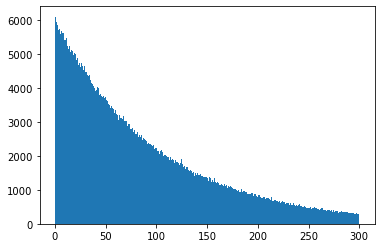

In [3]:
fig, ax = plt.subplots()
ax.hist(data_n, range=limits, bins=500)
plt.show()

In [4]:
obs = zfit.Space("mass", limits=limits)

mu = zfit.Parameter("mu", mu_true, mu_true - mu_true * 0.1, mu_true + mu_true * 0.1)
sigma = zfit.Parameter("sigma", sigma_true, sigma_true - sigma_true * 0.3, sigma_true + sigma_true * 0.3)
tau = zfit.Parameter("tau", -tau_true, -0.1, -0.00001)
frac = zfit.Parameter("frac", frac_true, 0, 1)

gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
exponential = zfit.pdf.Exponential(tau, obs=obs)
model = zfit.pdf.SumPDF([gauss, exponential], fracs=frac)

In [5]:
data = zfit.Data.from_numpy(obs=obs, array=data_n)

In [6]:
nll = zfit.loss.UnbinnedNLL(model=model, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, frac]] data=[<zfit.core.data.Data object at 0x7f537bcd43a0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00057 │ 998.2       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value    at limit
------  ---------  ----------
frac    0.0005833       False
mu          124.8       False
sigma      0.6991       False
tau      -0.01002       False


In [7]:
%%time

param_hesse = result.hesse() 
param_errors, new_result = result.errors()
print(result.params)

/home/massimiliano/python-devel/anaconda3/envs/stats-studies/lib/python3.9/site-packages/zfit/minimizers/fitresult.py:1097: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name        value    minuit_hesse         minuit_minos    at limit
------  ---------  --------------  -------------------  ----------
frac    0.0005833     +/- 0.00011  -0.00011   +0.00012       False
mu          124.8     +/-    0.16  -   0.16   +   0.15       False
sigma      0.6991     +/-    0.15  -   0.14   +  0.081       False
tau      -0.01002     +/- 1.4e-05  -1.5e-05   +1.4e-05       False
CPU times: user 52 s, sys: 1.53 s, total: 53.5 s
Wall time: 11.6 s


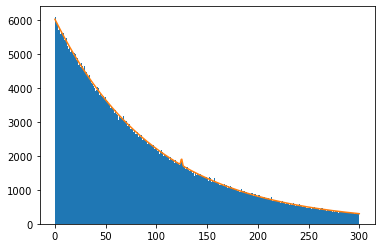

In [8]:
fig, ax = plt.subplots()
nbins=500
x = np.linspace(*limits, nbins)
base = (limits[1] - limits[0]) / nbins
histo, _ = np.histogram(data_n, nbins, limits)
plot_scale = np.sum(histo*base)
full = plot_scale * model.pdf(x, norm_range=limits).numpy()
ax.hist(data_n, range=limits, bins=nbins)
ax.plot(x, full)
plt.show()

In [9]:
frac_POI = POI(frac, 0)

In [10]:
as_calculator = AsymptoticCalculator(input=result, minimizer=minimizer)

In [11]:
fr_calculator = FrequentistCalculator(input=result, minimizer=minimizer)

In [12]:
discovery_as = Discovery(calculator=as_calculator, poinull=frac_POI)

In [13]:
discovery_as.result()


p_value for the Null hypothesis = 5.474776187952557e-11
Significance (in units of sigma) = 6.453223727818812


(5.474776187952557e-11, 6.453223727818812)